# AUTOMATED ALGORITHMIC TRADING BOT WITH MACHINE LEARNING

In [44]:
# Import dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import os
import requests
import json
from dotenv import load_dotenv
from alpaca_trade_api.rest import TimeFrame 
import alpaca_trade_api as tradeapi
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
import csv
import datetime
from datetime import date,timedelta
from finta import TA


%matplotlib inline

### DEFINING OUR TICKERS

In [45]:
def sp500_tickers():
    csvpath = Path("Resources/500S&P.csv")
    portfolios = []
    with open(csvpath, newline = "") as csvfile:
        rows = csv.reader(csvfile)
        header = next(rows)
        for x in rows:
            ticker = x[0]
            portfolio = {
                "ticker": ticker
            }
            portfolios.append(portfolio)
    return portfolios

### ASKING THE USER TO CHOOSE A TICKER

In [46]:
stock = []
def sp500_list():
    ticker = input("Enter the ticker of the stock of your choice from the S&P 500 to trade: ").upper()
    portfolios = sp500_tickers()
    #print(portfolios)
    for tickers in portfolios:
        #print(tickers)
        if ticker == tickers["ticker"]:
            stock.append(ticker)
            print(f"Your choice of ticker to trade from the S&P500: {stock}")
    if len(stock) < 1:
        print(f"{stock} not found")
            
    return stock
sp500_list()

Enter the ticker of the stock of your choice from the S&P 500 to trade:  AAPL


Your choice of ticker to trade from the S&P500: ['AAPL']


['AAPL']

In [47]:
load_dotenv()

True

#### SETTING INPUT VALUES

In [48]:
# Input the Ticker, Timeframe, Initial Capital and Share values
timeframe = "1Day"
initial_capital = 100000
shares = 90

# Set the short window and long window
short_window = 4
long_window = 10

#### Setting Alpaca variables, Set the dates to backdate


In [50]:
#Set the variables for the Alpaca API and secret keys. 
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
alpaca_api_key 
alpaca_secret_key 

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Set the dates to backdate
current_date = date.today()
end_date = current_date - timedelta(1)
start_date = end_date - timedelta(548)
print(start_date)
print(end_date)

2020-10-21
2022-04-22


### Import, slice and clean the data and set it to the dataframe.

In [51]:
# Import the alpaca dataset into a Pandas Dataframe
ticker_df = alpaca.get_bars(
    stock,
   timeframe, 
   start=start_date,
   end=end_date,
   limit=None
).df

# Review the Alpaca DataFrame
display(ticker_df)

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2020-10-21 04:00:00+00:00,116.48,118.7050,116.4500,116.87,89946704,525413,117.484290,AAPL
2020-10-22 04:00:00+00:00,117.45,118.0400,114.5900,115.75,101989340,650716,115.970316,AAPL
2020-10-23 04:00:00+00:00,116.32,116.5500,114.2800,115.04,82773318,576742,114.985575,AAPL
2020-10-26 04:00:00+00:00,113.97,116.5500,112.8800,115.05,111850917,731755,114.613205,AAPL
2020-10-27 04:00:00+00:00,115.50,117.2800,114.5399,116.60,92297793,554036,116.318797,AAPL
...,...,...,...,...,...,...,...,...
2022-04-18 04:00:00+00:00,163.90,166.5984,163.5700,165.07,68843906,574584,164.928104,AAPL
2022-04-19 04:00:00+00:00,165.07,167.8200,163.9100,167.40,67670571,546952,166.549811,AAPL
2022-04-20 04:00:00+00:00,168.82,168.8800,166.1000,167.23,67524380,590860,167.349631,AAPL


In [52]:
# Filter the date index, close and vwap columns
signals_df = ticker_df.loc[:, ["close", "vwap"]]

#### Calculating RSI ( Relative Strength Index)

In [55]:
# Generating RSI by using TA function
signals_df["RSI"] = TA.RSI(ticker_df)
signals_df

,close,vwap,RSI
timestamp,,,
2020-10-21 04:00:00+00:00,116.87,117.484290,NaN
2020-10-22 04:00:00+00:00,115.75,115.970316,0.000000
2020-10-23 04:00:00+00:00,115.04,114.985575,0.000000
2020-10-26 04:00:00+00:00,115.05,114.613205,0.611621
2020-10-27 04:00:00+00:00,116.60,116.318797,50.820626
...,...,...,...
2022-04-18 04:00:00+00:00,165.07,164.928104,44.066949
2022-04-19 04:00:00+00:00,167.40,166.549811,47.707999
2022-04-20 04:00:00+00:00,167.23,167.349631,47.465220


#### Generate the trading Signals using short-window, long-window SMAs and RSI values. 

In [57]:
# Generate the fast and slow simple moving averages 
signals_df['SMA_FAST'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_SLOW'] = signals_df['close'].rolling(window=long_window).mean()

# Initialize the new Signal column
signals_df['SMA_Signal'] = 0.0

In [58]:
# Generate the trading signal 1 or 0,

# where 1 is when the SMA_FAST is greater than the SMA_SLOW and RSI is greater than 50
# where 0 is when the SMA_FAST is less than than the SMA_SLOW and RSI is less than 50

# Generating the SMA_Signal
signals_df['SMA_Signal'][short_window:] = np.where(
    signals_df['SMA_FAST'][short_window:] > signals_df['SMA_SLOW'][short_window:], 1.0, 0.0
)
# Generating the RSI_Signal
signals_df["RSI_Signal"] = np.where(
    signals_df["RSI"] >= 50, 1.0, 0.0
)
# Generating the trading Signal by multiplying the SMA_Signal with the RSI Signal 
signals_df["Signal"] = signals_df['SMA_Signal'][short_window:] * signals_df["RSI_Signal"]                                          
                                                 
# Calculate the points in time at which a position should be taken, 1 or -1
signals_df['Entry/Exit'] = signals_df['Signal'].diff()
signals_df = signals_df.fillna(0)

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail(20))


,close,vwap,RSI,SMA_FAST,SMA_SLOW,SMA_Signal,RSI_Signal,Signal,Entry/Exit
timestamp,,,,,,,,,
2020-10-21 04:00:00+00:00,116.87,117.484290,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0
2020-10-22 04:00:00+00:00,115.75,115.970316,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0
2020-10-23 04:00:00+00:00,115.04,114.985575,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0
2020-10-26 04:00:00+00:00,115.05,114.613205,0.611621,115.6775,0.0,0.0,0.0,0.0,0.0
2020-10-27 04:00:00+00:00,116.60,116.318797,50.820626,115.6100,0.0,0.0,1.0,0.0,0.0


,close,vwap,RSI,SMA_FAST,SMA_SLOW,SMA_Signal,RSI_Signal,Signal,Entry/Exit
timestamp,,,,,,,,,
2022-03-25 04:00:00+00:00,174.72,174.023360,63.339264,171.9550,164.310,1.0,1.0,1.0,0.0
2022-03-28 04:00:00+00:00,175.60,174.375441,64.230977,173.6500,166.808,1.0,1.0,1.0,0.0
2022-03-29 04:00:00+00:00,178.96,177.851860,67.483148,175.8375,169.195,1.0,1.0,1.0,0.0
2022-03-30 04:00:00+00:00,177.77,178.119343,65.221377,176.7625,171.013,1.0,1.0,1.0,0.0
2022-03-31 04:00:00+00:00,174.61,175.876423,59.516869,176.7350,172.412,1.0,1.0,1.0,0.0
2022-04-01 04:00:00+00:00,174.31,173.413651,58.989371,176.4125,173.445,1.0,1.0,1.0,0.0
2022-04-04 04:00:00+00:00,178.44,177.485223,63.752306,176.2825,174.751,1.0,1.0,1.0,0.0
2022-04-05 04:00:00+00:00,175.06,175.978639,57.832573,175.6050,175.375,1.0,1.0,1.0,0.0
2022-04-06 04:00:00+00:00,171.59,171.784223,52.448211,174.8500,175.513,0.0,1.0,0.0,-1.0


In [59]:
# Visualize exit position relative to close price
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df[['SMA_FAST', 'SMA_SLOW']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize rsi (relative strength index)
rsi = signals_df[['RSI']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize vwap ( volume_weighted average price)
vwap = ticker_df[['vwap']].hvplot(
    color= "grey",
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='black',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close * moving_avgs * entry * exit * rsi * vwap

# Show the plot
entry_exit_plot.opts(
    title="SMA_SLOW, SMA_FAST, RSI, VWAP, ENTRY and EXIT Points"
)

:Overlay
   .Curve.I          :Curve   [timestamp]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)
   .Scatter.Close.I  :Scatter   [timestamp]   (close)
   .Scatter.Close.II :Scatter   [timestamp]   (close)
   .Curve.II         :Curve   [timestamp]   (RSI)
   .Curve.III        :Curve   [timestamp]   (vwap)

In [60]:
signals_df.hvplot(width=1000,
    height=400,)

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

### BACKTESTING OUR ALGORITHIM



In [61]:
# Remove the columns that are not needed in this process
signals_df = signals_df.drop(["vwap", "SMA_Signal", "RSI_Signal"], axis=1)

In [62]:
# Pull the value set for the initial_capital investment and the share size of each trade. The following code sets up these two variables:
# Set initial capital
initial_capital = float(initial_capital)

# Set the share size
share_size = shares 

In [63]:
# Buy the number of share position when the "Signal" equals 1 
# Sell the same anount of share position when the "Signal" equals 0 
signals_df['Position'] = share_size * signals_df['Signal']


In [64]:
# Determine the points in time where the share_size position is bought or sold
signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

In [65]:
# Multiply the close price by the number of shares held, or the Position
signals_df['Portfolio Holdings'] = signals_df['close'] * signals_df['Position']

In [66]:
# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
signals_df['Portfolio Cash'] = initial_capital - (signals_df['close'] * signals_df['Entry/Exit Position']).cumsum()

In [67]:
# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

In [68]:
# Calculate the portfolio daily returns
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

In [69]:
# Calculate the portfolio cumulative returns
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1


In [70]:
# Print the DataFrame
signals_df.dropna()
#display(signals_df.head(100))
display(signals_df.tail(23))
#display(signals_df)


,close,RSI,SMA_FAST,SMA_SLOW,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
timestamp,,,,,,,,,,,,,
2022-03-22 04:00:00+00:00,168.82,57.226308,164.7000,160.030,1.0,0.0,90.0,0.0,15193.8,86698.9,101892.7,0.003048,0.018927
2022-03-23 04:00:00+00:00,170.21,58.743915,167.0975,160.756,1.0,0.0,90.0,0.0,15318.9,86698.9,102017.8,0.001228,0.020178
2022-03-24 04:00:00+00:00,174.07,62.701508,169.6200,162.311,1.0,0.0,90.0,0.0,15666.3,86698.9,102365.2,0.003405,0.023652
2022-03-25 04:00:00+00:00,174.72,63.339264,171.9550,164.310,1.0,0.0,90.0,0.0,15724.8,86698.9,102423.7,0.000571,0.024237
2022-03-28 04:00:00+00:00,175.60,64.230977,173.6500,166.808,1.0,0.0,90.0,0.0,15804.0,86698.9,102502.9,0.000773,0.025029
2022-03-29 04:00:00+00:00,178.96,67.483148,175.8375,169.195,1.0,0.0,90.0,0.0,16106.4,86698.9,102805.3,0.002950,0.028053
2022-03-30 04:00:00+00:00,177.77,65.221377,176.7625,171.013,1.0,0.0,90.0,0.0,15999.3,86698.9,102698.2,-0.001042,0.026982
2022-03-31 04:00:00+00:00,174.61,59.516869,176.7350,172.412,1.0,0.0,90.0,0.0,15714.9,86698.9,102413.8,-0.002769,0.024138
2022-04-01 04:00:00+00:00,174.31,58.989371,176.4125,173.445,1.0,0.0,90.0,0.0,15687.9,86698.9,102386.8,-0.000264,0.023868


### MACHINE LEARNING


In [71]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X ( Features set)
X = signals_df[['RSI','SMA_FAST', 'SMA_SLOW']].shift().dropna()

# Review the DataFrame
X.head()

,RSI,SMA_FAST,SMA_SLOW
timestamp,,,
2020-10-22 04:00:00+00:00,0.000000,0.0000,0.0
2020-10-23 04:00:00+00:00,0.000000,0.0000,0.0
2020-10-26 04:00:00+00:00,0.000000,0.0000,0.0
2020-10-27 04:00:00+00:00,0.611621,115.6775,0.0
2020-10-28 04:00:00+00:00,50.820626,115.6100,0.0


In [72]:
# Create the target set selecting the Signal column and assiging it to y (Target set)
y = signals_df['Signal']

# Review the value counts
y.value_counts()

0.0    196
1.0    183
Name: Signal, dtype: int64

In [73]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2020-10-22 04:00:00+00:00


In [74]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2021-01-22 04:00:00+00:00


In [75]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()
X_train.tail()

,RSI,SMA_FAST,SMA_SLOW
timestamp,,,
2021-01-14 05:00:00+00:00,55.149322,130.1800,130.507
2021-01-15 05:00:00+00:00,51.287039,129.3950,130.026
2021-01-19 05:00:00+00:00,48.047610,128.9350,129.471
2021-01-20 05:00:00+00:00,49.389636,128.6925,129.313
2021-01-21 05:00:00+00:00,56.718583,128.9775,129.415


In [76]:
# Generate the X_test and y_test DataFrames
#X_test = X.loc[training_end+DateOffset(hours=1):]
#y_test = y.loc[training_end+DateOffset(hours=1):]
X_test = X.loc[training_end+DateOffset(months=3):]
y_test = y.loc[training_end+DateOffset(months=3):]

# Review the X_test DataFrame
X_test.head()

,RSI,SMA_FAST,SMA_SLOW
timestamp,,,
2021-04-22 04:00:00+00:00,60.622818,133.88875,133.12126
2021-04-23 04:00:00+00:00,56.631408,133.35750,133.27926
2021-04-26 04:00:00+00:00,60.889486,133.21750,133.41176
2021-04-27 04:00:00+00:00,61.572375,133.61750,133.74676
2021-04-28 04:00:00+00:00,60.631796,133.84250,133.74550


#### Standardizing the Data

In [77]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [79]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
#svm_model = svm_model.fit(X_resampled, y_resampled) 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]


array([1., 0., 1., 1., 1., 0., 0., 0., 0., 0.])

#### Review the classification report associated with the SVC model predictions.

In [82]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print("SVM Classification Report")
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

         0.0       0.57      0.99      0.72       126
         1.0       0.97      0.25      0.40       128

    accuracy                           0.62       254
   macro avg       0.77      0.62      0.56       254
weighted avg       0.77      0.62      0.56       254



#### Create a predictions DataFrame that contains columns for “Predicted” values, “Portfolio Daily Returns”, and “Trading Algorithm Returns”. (Option 1)

In [83]:
# Create a predictions DataFrame
svm_predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
svm_predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
#predictions_df['Actual Returns'] = signals_df["Actual Returns"]
svm_predictions_df['Portfolio Daily Returns'] = signals_df["Portfolio Daily Returns"]
# Add the strategy returns to the DataFrame
svm_predictions_df['Trading Algorithm Returns'] = svm_predictions_df['Portfolio Daily Returns'] * svm_predictions_df['Predicted']

# Review the DataFrame
display(svm_predictions_df.head())
display(svm_predictions_df.tail())

,Predicted,Portfolio Daily Returns,Trading Algorithm Returns
timestamp,,,
2021-04-22 04:00:00+00:00,1.0,-0.001392,-0.001392
2021-04-23 04:00:00+00:00,0.0,0.002141,0.000000
2021-04-26 04:00:00+00:00,1.0,0.000000,0.000000
2021-04-27 04:00:00+00:00,1.0,0.000000,0.000000
2021-04-28 04:00:00+00:00,1.0,-0.000727,-0.000727


,Predicted,Portfolio Daily Returns,Trading Algorithm Returns
timestamp,,,
2022-04-18 04:00:00+00:00,0.0,0.0,0.0
2022-04-19 04:00:00+00:00,0.0,0.0,0.0
2022-04-20 04:00:00+00:00,0.0,0.0,0.0
2022-04-21 04:00:00+00:00,0.0,0.0,0.0
2022-04-22 04:00:00+00:00,0.0,0.0,0.0


#### Create a cumulative return plot that shows the Portfolio Daily Returns vs. the Trading Algorithm Returns. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

<AxesSubplot:xlabel='timestamp'>

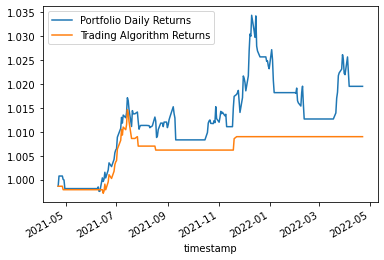

In [84]:
# Plot the Portfolio Daily Returns versus the Trading Algorithm Returns
(1 + svm_predictions_df[["Portfolio Daily Returns", "Trading Algorithm Returns"]]).cumprod().plot()

#### Apply Ada Boost algorithm to improve the accuracy score (random_state = 0).

In [85]:
adbst = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1,
                         random_state=0)

ada_model = adbst.fit(X_train_scaled, y_train)

ada_pred = ada_model.predict(X_test_scaled)
ada_pred [:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Review the classification report associated with the Ada Boost model predictions.

In [86]:
# Use a classification report to evaluate the model using the predictions and testing data
ada_testing_report = classification_report(y_test, ada_pred)

# Print the classification report
print("ADA Boost Classification Report")
print(ada_testing_report)

ADA Boost Classification Report
              precision    recall  f1-score   support

         0.0       0.51      0.99      0.68       126
         1.0       0.91      0.08      0.14       128

    accuracy                           0.53       254
   macro avg       0.71      0.54      0.41       254
weighted avg       0.71      0.53      0.41       254



#### Create a predictions DataFrame that contains columns for “Predicted” values, “Portfolio Daily Returns”, and “Trading Algorithm Returns”.

In [87]:
# Create a predictions DataFrame
ada_predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
ada_predictions_df['Predicted'] = ada_pred

# Add the actual returns to the DataFrame
#predictions_df['Actual Returns'] = signals_df["Actual Returns"]
ada_predictions_df['Portfolio Daily Returns'] = signals_df["Portfolio Daily Returns"]
# Add the strategy returns to the DataFrame
ada_predictions_df['Trading Algorithm Returns'] = ada_predictions_df['Portfolio Daily Returns'] * ada_predictions_df['Predicted']

# Review the DataFrame
display(ada_predictions_df.head())
display(ada_predictions_df.tail())

,Predicted,Portfolio Daily Returns,Trading Algorithm Returns
timestamp,,,
2021-04-22 04:00:00+00:00,0.0,-0.001392,-0.0
2021-04-23 04:00:00+00:00,0.0,0.002141,0.0
2021-04-26 04:00:00+00:00,0.0,0.000000,0.0
2021-04-27 04:00:00+00:00,0.0,0.000000,0.0
2021-04-28 04:00:00+00:00,0.0,-0.000727,-0.0


,Predicted,Portfolio Daily Returns,Trading Algorithm Returns
timestamp,,,
2022-04-18 04:00:00+00:00,0.0,0.0,0.0
2022-04-19 04:00:00+00:00,0.0,0.0,0.0
2022-04-20 04:00:00+00:00,0.0,0.0,0.0
2022-04-21 04:00:00+00:00,0.0,0.0,0.0
2022-04-22 04:00:00+00:00,0.0,0.0,0.0


#### Create a cumulative return plot that shows the Portfolio Daily Returns vs. the Trading Algorithm Returns. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

<AxesSubplot:xlabel='timestamp'>

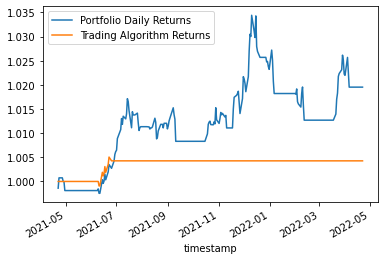

In [88]:
# Plot the Portfolio Daily Returns versus the Trading Algorithm Returns
(1 + ada_predictions_df[["Portfolio Daily Returns", "Trading Algorithm Returns"]]).cumprod().plot()